# Part A: Predicting Factory Machine Status
### Seow Yue Jia Tiffanee (2415732)
#### Background
This is a dataset collected from a manufacturing factory. The dataset contains various information on different machines. From the perspective of quality control, the factory wants to build a machine learning model to predict whether the machine is working properly or faulty.

Aim: We want to predict whether the machine is working properly or faulty using our features. Our target feature is machine status, as it tells us if the machine is working normally or not with boolean values 0 (normal) and 1 (abnormal)

## imports

In [1]:
# BASIC
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# GRAPH PLOTTING
import matplotlib.pyplot as plt

# SCI-KIT LEARN
# model building
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.dummy import DummyClassifier

# model evaluation
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    f1_score,
    roc_curve,
    auc
)

# model improvement
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_predict,
    learning_curve,
    StratifiedKFold,
    KFold
)

## data exploration

### step 1: import the dataset

In [111]:
df = pd.read_csv('datasets/factory_data.csv')
df.head()

,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
0,1,K12965,M,24.95,35.45,1551.0,42.8,0,0
1,2,Z62710,L,25.05,35.55,1408.0,46.3,3,0
2,3,T20224,L,24.95,35.35,1498.0,49.4,5,0
3,4,Z33024,L,25.05,35.45,1433.0,39.5,7,0
4,5,Z52839,L,25.05,35.55,1408.0,40.0,9,0


### step 2: summary statistics

In [112]:
print(f'Number of rows: {df.shape[0]}, Number of columns: {df.shape[1]}')

Number of rows: 20000, Number of columns: 9


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unique ID             20000 non-null  int64  
 1   Product ID            20000 non-null  object 
 2   Quality               19009 non-null  object 
 3   Ambient T (C)         20000 non-null  float64
 4   Process T (C)         19600 non-null  float64
 5   Rotation Speed (rpm)  18812 non-null  float64
 6   Torque (Nm)           20000 non-null  float64
 7   Tool Wear (min)       20000 non-null  int64  
 8   Machine Status        20000 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 1.4+ MB


<b>obervations<b>
- there are 20000 rows and 9 columns in our dataset (8 features, 1 target)
- there is missing data for Quality, Process T (C), Rotation Speed (rpm)
- Product ID and Quality are non-numeric data
- we can drop unique ID and product ID as they are machine identifiers and does not affect our dataset

#### taking a look at the numerical values in the dataset

In [114]:
df.describe()

,Unique ID,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
count,20000.000000,20000.000000,19600.000000,18812.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,26.904930,36.904291,1538.795397,39.986910,107.951000,0.033900
std,5773.647028,2.000834,1.483647,178.674963,9.968684,63.652555,0.180976
min,1.000000,22.150000,32.550000,1168.000000,3.800000,0.000000,0.000000
25%,5000.750000,25.250000,35.750000,1423.000000,33.200000,53.000000,0.000000
50%,10000.500000,26.950000,36.950000,1503.000000,40.100000,108.000000,0.000000
75%,15000.250000,28.450000,37.950000,1613.000000,46.800000,162.000000,0.000000
max,20000.000000,31.450000,40.750000,2886.000000,76.600000,253.000000,1.000000


#### check for missing data in df

In [115]:
print(df.isnull().sum())

Unique ID                  0
Product ID                 0
Quality                  991
Ambient T (C)              0
Process T (C)            400
Rotation Speed (rpm)    1188
Torque (Nm)                0
Tool Wear (min)            0
Machine Status             0
dtype: int64


### step 3: univariate analysis

#### finding out the distribution of boolean values of machine status (target)

In [116]:
df["Machine Status"].unique()

array([0, 1], dtype=int64)

In [2]:
count = df['Machine Status'].value_counts()
machine_status = count.values
labels = count.index.astype(str)

plt.pie(machine_status, labels=labels, autopct='%1.1f%%')
plt.title("Distribution of Machine Status")
plt.show()

NameError: name 'df' is not defined

i can see that there are way more 0 values than 1; this is good, as 0 means normal and 1 means abnormal
however, this means that our target value is unbalanced, hence we would have to look at other metrics like f1 score and recall instead of accuracy to evaluate our model

#### looking at the quality feature

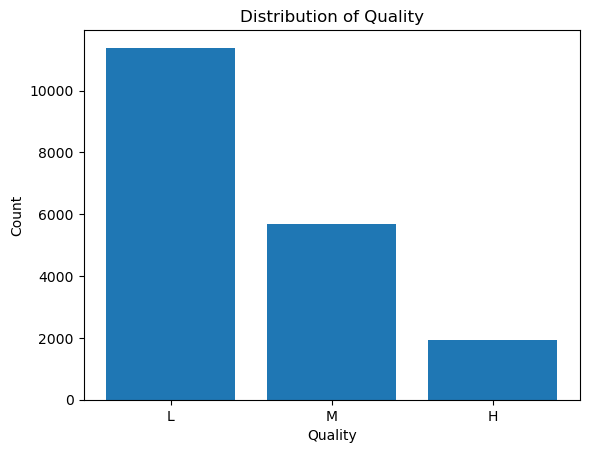

In [118]:
count = df['Quality'].value_counts()
plt.bar(count.index, count.values)
plt.title("Distribution of Quality")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

observations:
- the quality feature has three classes, low, medium, and high
- a large portion of the values are in the class 'low' -- taken in the real world context, this may mean that the quality of the machines are bad and may not perform as well as those in the 'medium' and 'high' classes
- we will need to convert these categorial features into numerical ones later while we clean the data

#### histograms

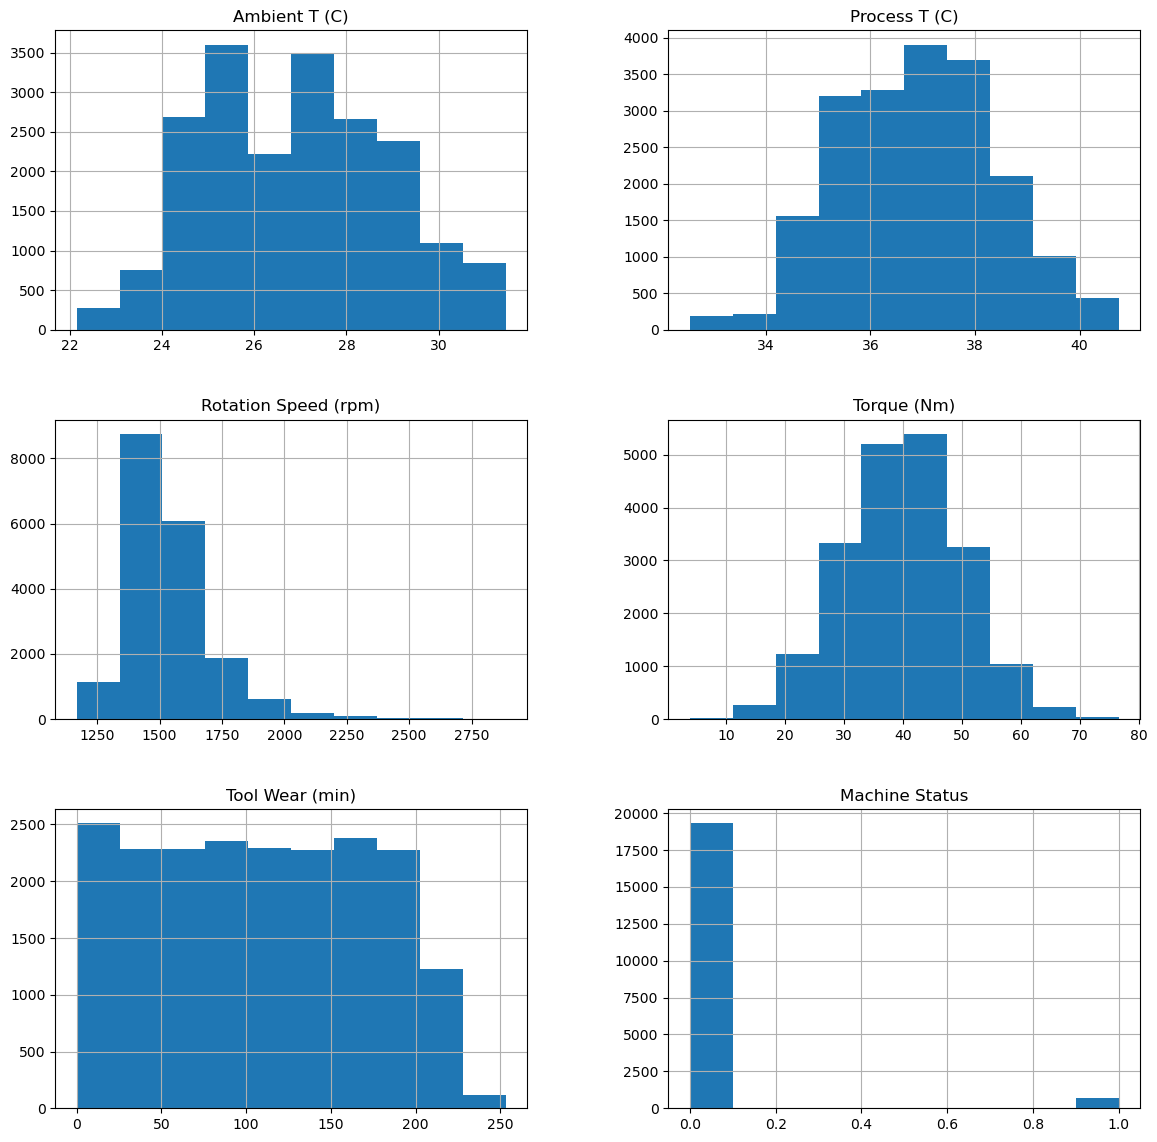

In [119]:
df_copy = df.copy()
df_copy = df_copy.drop(['Quality', 'Product ID', 'Unique ID'], axis = 1)
df_copy.hist(figsize=(14,14))
plt.show()

#### boxplot and finding outliers

In [120]:
df_copy2 = df.copy()

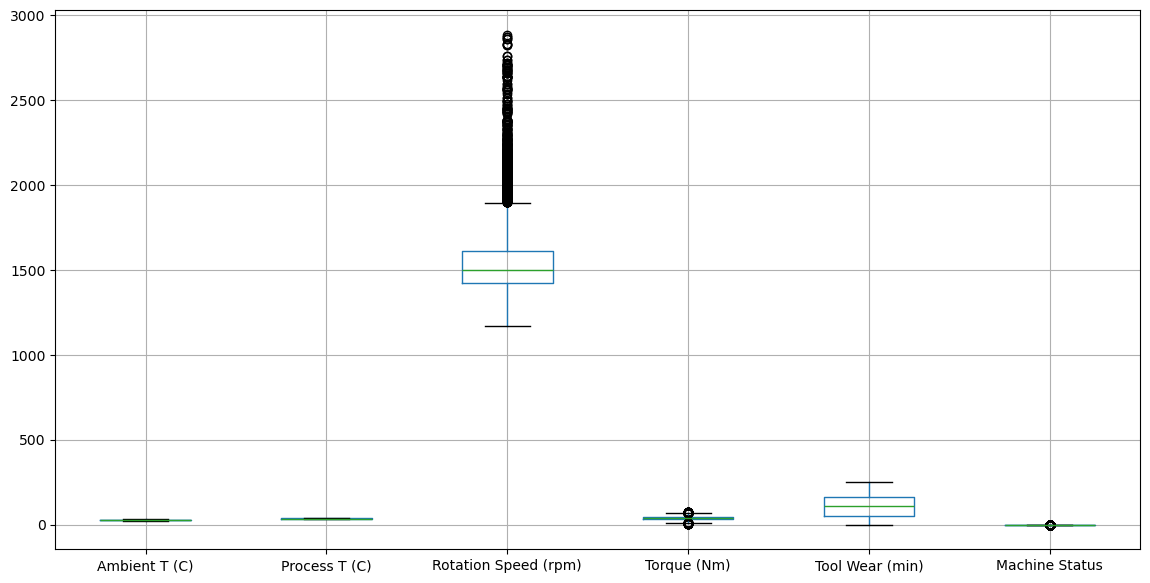

Column: Ambient T (C), Outliers: 0
Column: Process T (C), Outliers: 0
Column: Rotation Speed (rpm), Outliers: 771
Column: Torque (Nm), Outliers: 138
Column: Tool Wear (min), Outliers: 0
Column: Machine Status, Outliers: 678
Total number of outliers across all columns: 1587


In [121]:
df_copy2 = df_copy2.drop(['Quality', 'Unique ID', 'Product ID'], axis=1)

df_copy2.boxplot(figsize=(14, 7))

total_outliers = 0

# Loop through each numerical column to calculate outliers
for column in df_copy2.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df_copy2[column].quantile(0.25)
    Q3 = df_copy2[column].quantile(0.75)
    IQR = Q3 - Q1
    # Identify outliers based on the IQR rule
    outliers = (df_copy2[column] < Q1 - 1.5 * IQR) | (df_copy2[column] > Q3 + 1.5 * IQR)
    plt.show()
    # Count the number of outliers for this column
    num_outliers = outliers.sum()  # True values are counted as 1
    total_outliers += num_outliers
    print(f"Column: {column}, Outliers: {num_outliers}")
print(f"Total number of outliers across all columns: {total_outliers}")

- we note that the only outliers are in Rotation Speed (rpm), Machine Status and Torque (Nm)
- the outliers for Torque still falls within natural range, hence we do not need to do anything
- there are 771 outliers in Rotation Speed, about 4% of the data and they all fall on the right hand size of the box plot (positively-skewed), even though it is a small percentage of the data, we will still try our best to impute it
- we can use mode to impute the outliers for machine status

### step 4: bivariate analysis

#### heatmap

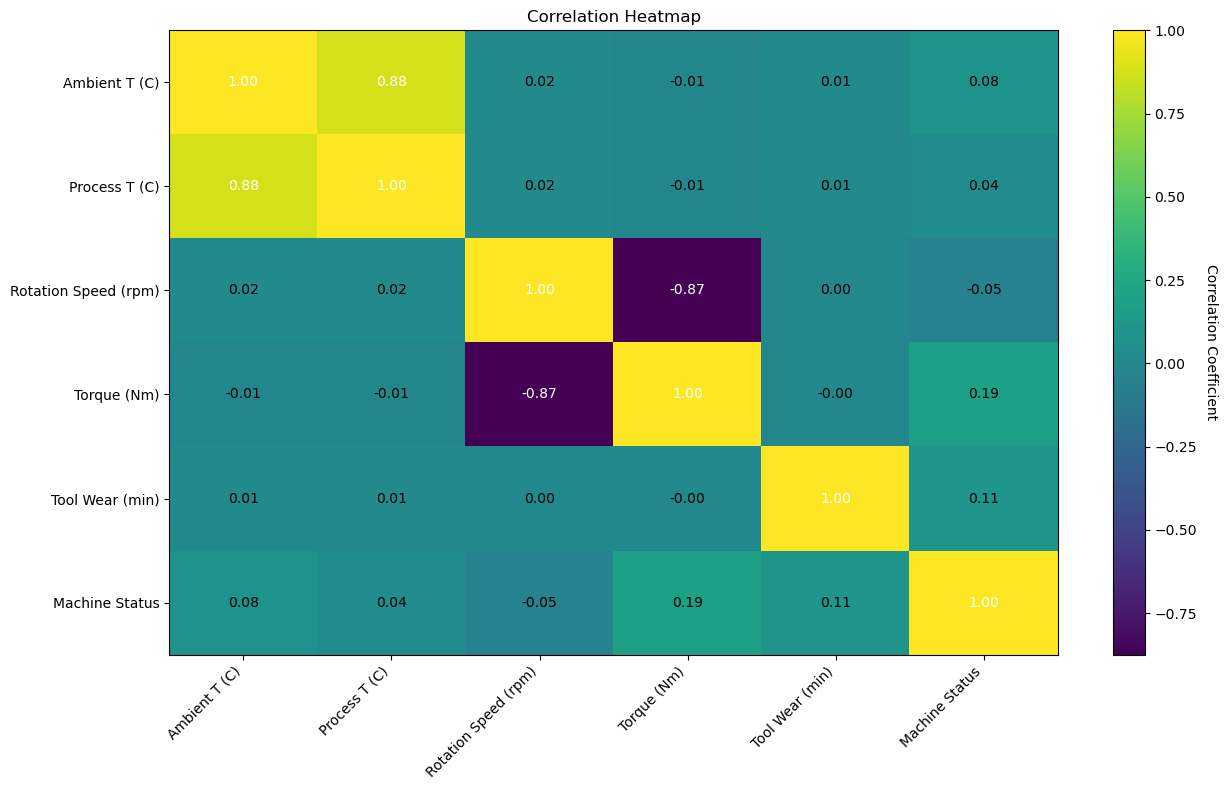

In [122]:
correlation_matrix = df_copy.corr()

fig, ax = plt.subplots(figsize=(13, 8))
heatmap = ax.imshow(correlation_matrix, cmap="viridis", aspect="auto")

cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=15)

ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha="right")
ax.set_yticks(range(len(correlation_matrix.index)))
ax.set_yticklabels(correlation_matrix.index)

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.index)):
        ax.text(
            j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
            ha="center", va="center", color="white" if np.abs(correlation_matrix.iloc[i, j]) > 0.5 else "black"
        )

ax.set_title("Correlation Heatmap")
plt.tight_layout()
plt.show()

#### pairplot

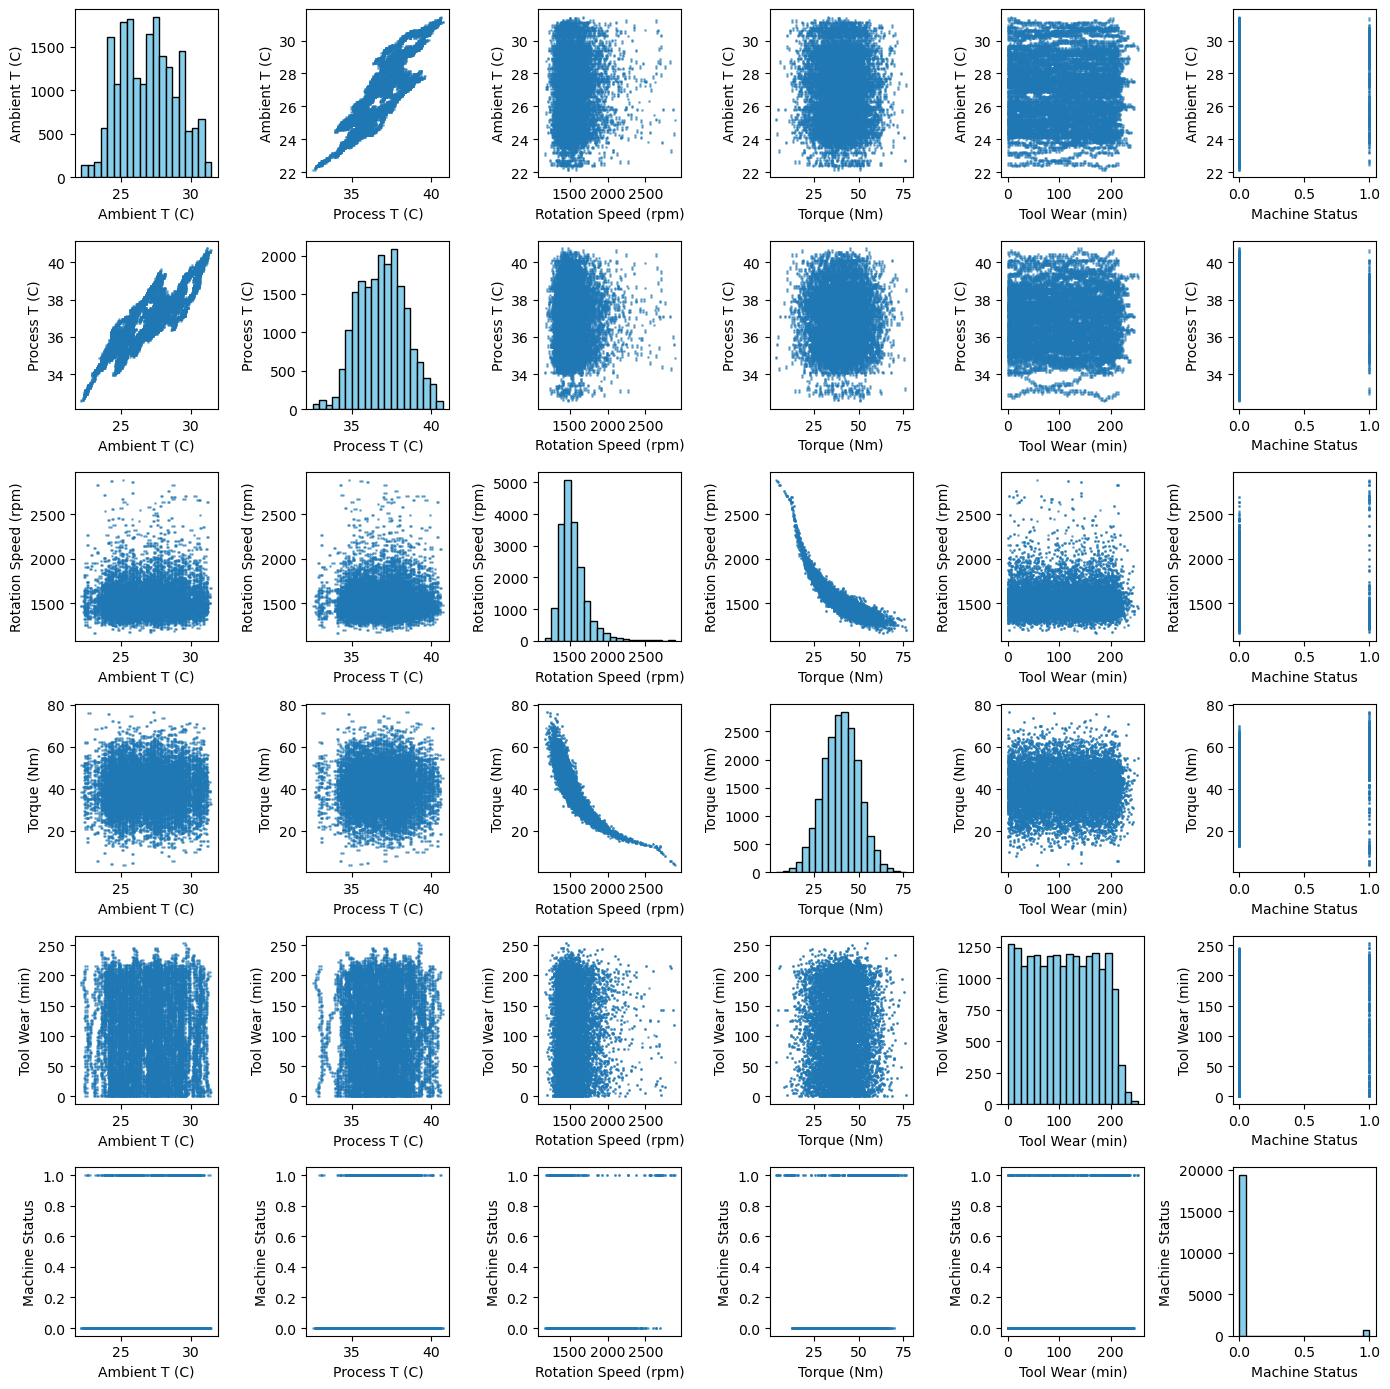

In [123]:
columns = df_copy.columns

n = len(columns)

fig, axes = plt.subplots(n, n, figsize=(14, 14))

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        
        if i == j:
            # Diagonal: Plot histograms for the features
            ax.hist(df_copy[columns[i]], bins=20, color="skyblue", edgecolor="black")
            ax.set_xlabel(columns[i])
            ax.set_ylabel(columns[i])
        else:
            # Off-diagonal: Plot scatter plots for feature pairs
            ax.scatter(df_copy[columns[j]], df_copy[columns[i]], alpha=0.5, s = 1)
            ax.set_xlabel(columns[j])
            ax.set_ylabel(columns[i])

plt.tight_layout()
plt.show()

### step 5: feature engineering

#### ignore redundant columns
Unique ID and Product ID are identifiers for the machine, hence they are not of any use to our model

In [124]:
df = df.drop(['Unique ID', 'Product ID'], axis = 1)

#### dummy encoding for 'Quality' column

In [125]:
df = pd.get_dummies(df, drop_first = True)
df.head()

,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status,Quality_L,Quality_M
0,24.95,35.45,1551.0,42.8,0,0,False,True
1,25.05,35.55,1408.0,46.3,3,0,True,False
2,24.95,35.35,1498.0,49.4,5,0,True,False
3,25.05,35.45,1433.0,39.5,7,0,True,False
4,25.05,35.55,1408.0,40.0,9,0,True,False


#### impute missing values

In [126]:
df['Process T (C)'] = df['Process T (C)'].fillna(df['Process T (C)'].mean())
df['Rotation Speed (rpm)'] = df['Rotation Speed (rpm)'].fillna(df['Rotation Speed (rpm)'].median())
df['Quality_L'] = df['Quality_L'].fillna(method = 'ffill')
df['Quality_M'] = df['Quality_M'].fillna(method = 'ffill')

- used median to impute rotation speed as it is positively skewed as seen from the box plot and histogram
- used forwardfill on Quality_L and Quality_M
- used mean to impute process T as it had a fairly normal distribution

#### handling outliers

In [127]:
df['Rotation Speed (rpm)'] = np.log1p(df['Rotation Speed (rpm)'])

#### train test split

In [128]:
y = df[['Machine Status']]
X = df[['Quality_L', 'Quality_M', 'Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y, shuffle = True, random_state = 42)

## model building & model evaluation

### baseline model

In [20]:
dc = DummyClassifier(strategy = "most_frequent")
dc.fit(X_train, y_train)
dc_predict = dc.predict(X_test)
print(classification_report(y_test, dc_predict))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3864
           1       0.00      0.00      0.00       136

    accuracy                           0.97      4000
   macro avg       0.48      0.50      0.49      4000
weighted avg       0.93      0.97      0.95      4000



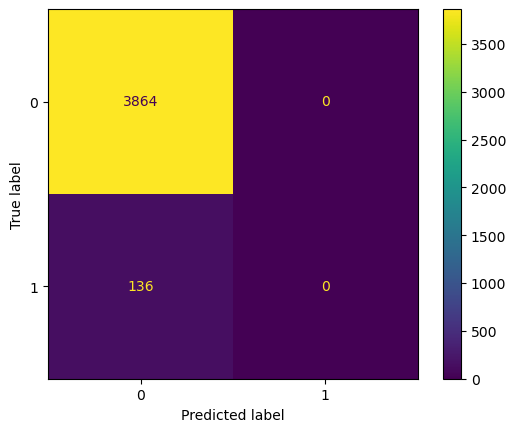

In [21]:
dcCM = confusion_matrix(y_test, dc_predict)
display = ConfusionMatrixDisplay(dcCM)
display.plot()

observations: 
- f1 score for 0 is very high at 0.98, while it is at 0.00 for 1
- this indicates a heavy bias towards 0, and the model is probably unable to recognise the minority class 1 (or it will never predict 1 correctly)
- our dataset is clearly imbalanced

### k neighbors classifier

In [22]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)
print(classification_report(y_test, knn_predict))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3864
           1       0.83      0.52      0.64       136

    accuracy                           0.98      4000
   macro avg       0.90      0.76      0.81      4000
weighted avg       0.98      0.98      0.98      4000



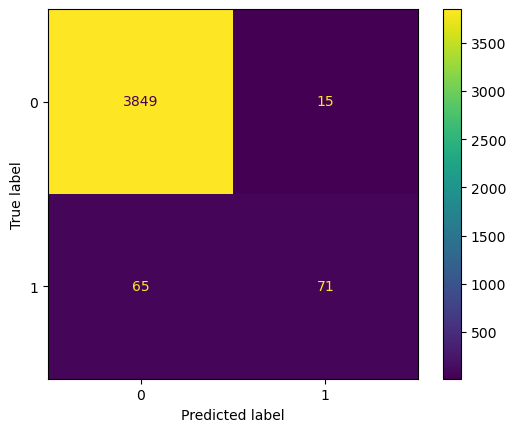

In [23]:
knnCM = confusion_matrix(y_test, knn_predict)
display = ConfusionMatrixDisplay(knnCM)
display.plot()

### naive bayes

In [24]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_predict = nb.predict(X_test)
print(classification_report(y_test, nb_predict))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3864
           1       0.42      0.22      0.29       136

    accuracy                           0.96      4000
   macro avg       0.69      0.60      0.63      4000
weighted avg       0.95      0.96      0.96      4000



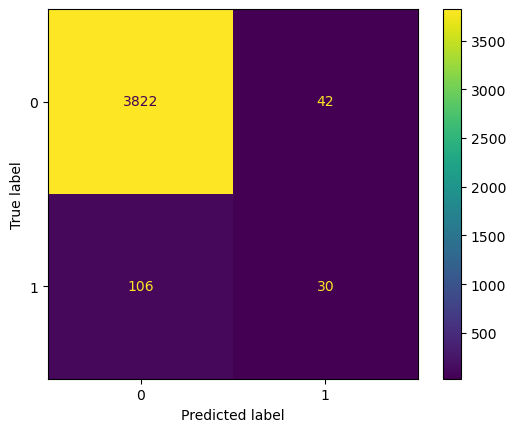

In [25]:
nbCM = confusion_matrix(y_test, nb_predict)
display = ConfusionMatrixDisplay(nbCM)
display.plot()

### logistic regression

In [26]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
print(classification_report(y_test, lr_predict))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84      3864
           1       0.09      0.74      0.16       136

    accuracy                           0.73      4000
   macro avg       0.54      0.74      0.50      4000
weighted avg       0.96      0.73      0.82      4000



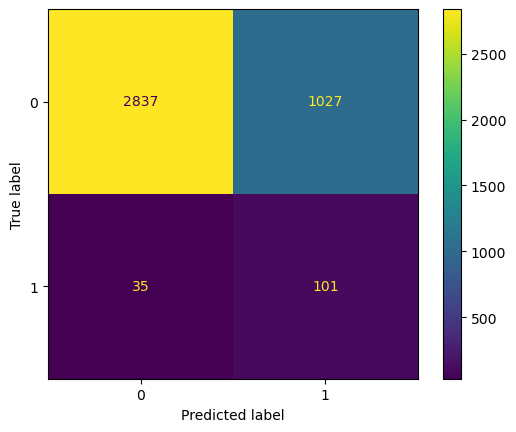

In [27]:
lrCM = confusion_matrix(y_test, lr_predict)
display = ConfusionMatrixDisplay(lrCM)
display.plot()

### histgradientbooster

In [28]:
hgbc = HistGradientBoostingClassifier(random_state = 42)
hgbc.fit(X_train, y_train)
hgbc_predict = hgbc.predict(X_test)
print(classification_report(y_test, hgbc_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3864
           1       0.96      0.75      0.84       136

    accuracy                           0.99      4000
   macro avg       0.98      0.87      0.92      4000
weighted avg       0.99      0.99      0.99      4000



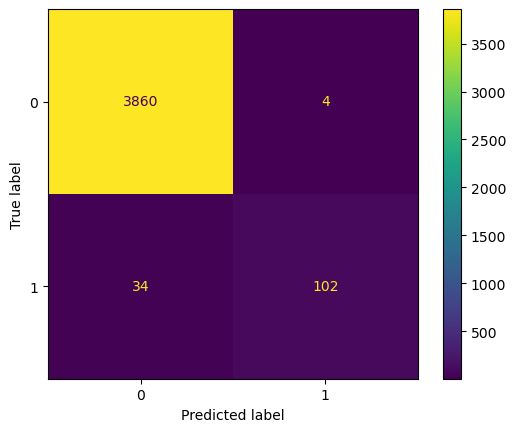

In [29]:
hgbcCM = confusion_matrix(y_test, hgbc_predict)
display = ConfusionMatrixDisplay(hgbcCM)
display.plot()

### decision tree

In [30]:
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(X_train, y_train)
dt_predict = dt.predict(X_test)
print(classification_report(y_test, dt_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3864
           1       0.88      0.86      0.87       136

    accuracy                           0.99      4000
   macro avg       0.94      0.93      0.93      4000
weighted avg       0.99      0.99      0.99      4000



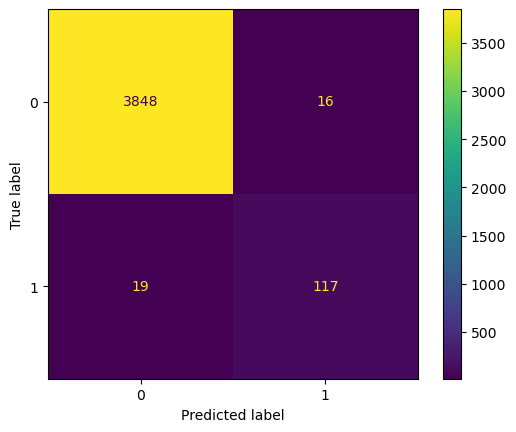

In [31]:
dtCM = confusion_matrix(y_test, dt_predict)
display = ConfusionMatrixDisplay(dtCM)
display.plot()

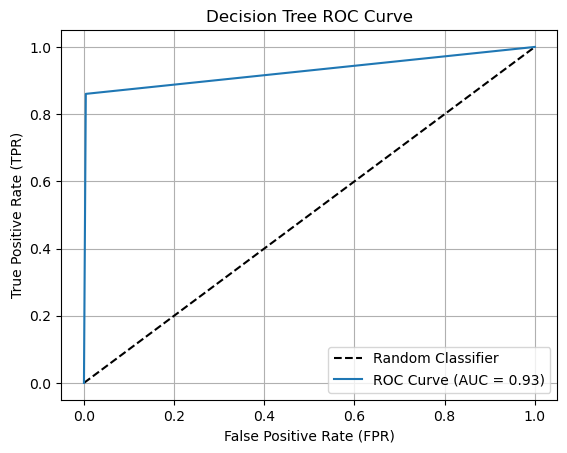

In [32]:
y_pred_probs = dt.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Decision Tree ROC Curve')
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

### random forest

In [33]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3864
           1       0.99      0.78      0.87       136

    accuracy                           0.99      4000
   macro avg       0.99      0.89      0.93      4000
weighted avg       0.99      0.99      0.99      4000



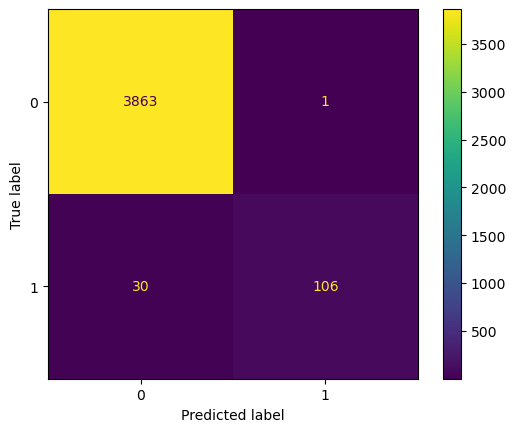

In [34]:
rfCM = confusion_matrix(y_test, rf_predict)
display = ConfusionMatrixDisplay(rfCM)
display.plot()

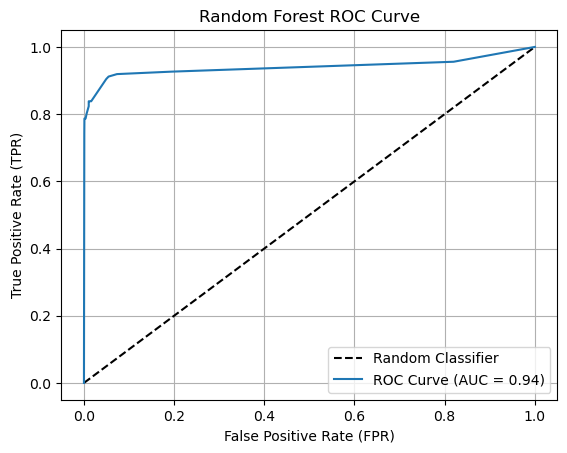

In [68]:
y_pred_probs = dt.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Random Forest ROC Curve')
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

## model improvement - tuning hyperparameters

now, compared to the baseline model, the decision tree and random forest performs the best

### decision tree

In [35]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

#### randomisedsearchcv

In [85]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
hp_grid = {
    'max_depth': np.arange(1, 13),
    'min_samples_leaf': [1, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 4, 5, 7, 10]
}
dt_grid1 = RandomizedSearchCV(estimator = dt, param_distributions = hp_grid, scoring = 'f1', cv = kf, n_iter = 150, verbose=3, n_jobs=-1)
dt_grid1.fit(X_train, y_train)

print(f'The best cross-validation score is {dt_grid1.best_score_}')
# the best model
print(f'The best max depth is {dt_grid1.best_estimator_.max_depth}')
print(f'The best min_samples_leaf is {dt_grid1.best_estimator_.min_samples_leaf}')
print(f'The best min_samples_split is {dt_grid1.best_estimator_.min_samples_split}')
# best hyperparameters
print(f'The best hyperparameters are {dt_grid1.best_params_}')

Fitting 5 folds for each of 150 candidates, totalling 750 fits
The best cross-validation score is 0.8086135124891232
The best max depth is 12
The best min_samples_leaf is 1
The best min_samples_split is 2
The best hyperparameters are {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 12}


#### gridsearchcv

In [86]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
hp_grid = {
    'max_depth': np.arange(1, 13),
    'min_samples_leaf': [1, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 4, 5, 7, 10]
}

dt_grid2 = GridSearchCV(estimator=dt, param_grid=hp_grid, scoring='recall', cv=kf, verbose=3, n_jobs=-1)
dt_grid2.fit(X_train, y_train)

print(f'The best cross-validation score is {dt_grid2.best_score_}')
print(f'The best max depth is {dt_grid2.best_estimator_.max_depth}')
print(f'The best min_samples_leaf is {dt_grid2.best_estimator_.min_samples_leaf}')
print(f'The best min_samples_split is {dt_grid2.best_estimator_.min_samples_split}')
print(f'The best hyperparameters are {dt_grid2.best_params_}')

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
The best cross-validation score is 0.7804137492375147
The best max depth is 12
The best min_samples_leaf is 1
The best min_samples_split is 2
The best hyperparameters are {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2}


#### retesting the model

In [83]:
dt = DecisionTreeClassifier(max_depth = 12, min_samples_leaf = 1, min_samples_split = 2, random_state = 42)
dt.fit(X_train, y_train)
dt_predict = dt.predict(X_test)
print(classification_report(y_test, dt_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3864
           1       0.94      0.79      0.86       136

    accuracy                           0.99      4000
   macro avg       0.97      0.89      0.93      4000
weighted avg       0.99      0.99      0.99      4000



### random forest

In [39]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

#### gridsearchcv

In [77]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
hp_grid = {
    'max_depth': [5, 10, 15, 20, 30, 45],
    'n_estimators': [100, 250, 450, 500, 750]
}

grid = GridSearchCV(estimator=rf, param_grid=hp_grid, scoring='f1', cv=kf, verbose=3, n_jobs=-1)
grid.fit(X_train, y_train)

print(f'The best cross-validation score is {grid.best_score_}')
print(f'The best max depth is {grid.best_estimator_.max_depth}')
print(f'The best min_samples_leaf is {grid.best_estimator_.n_estimators}')
print(f'The best hyperparameters are {grid.best_params_}')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
The best cross-validation score is 0.8345877273232629
The best max depth is 20
The best min_samples_leaf is 500
The best hyperparameters are {'max_depth': 20, 'n_estimators': 500}


#### randomizedsearchcv

In [72]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
hp_grid = {
    'max_depth': np.arange(10, 61),
    'n_estimators': np.arange(100, 201)
}
grid2 = RandomizedSearchCV(estimator = rf, param_distributions = hp_grid, scoring = 'f1', cv = kf, verbose=3, n_jobs=-1)
grid2.fit(X_train, y_train)

print(f'The best cross-validation score is {grid2.best_score_}')
# the best model
print(f'The best max depth is {grid2.best_estimator_.max_depth}')
print(f'The best min_samples_leaf is {grid2.best_estimator_.n_estimators}')
# best hyperparameters
print(f'The best hyperparameters are {grid2.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best cross-validation score is 0.8342819700794672
The best max depth is 35
The best min_samples_leaf is 123
The best hyperparameters are {'n_estimators': 123, 'max_depth': 35}


#### retesting the model

In [73]:
rf = RandomForestClassifier(max_depth = 35, n_estimators = 123, random_state = 42)
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3864
           1       1.00      0.79      0.88       136

    accuracy                           0.99      4000
   macro avg       1.00      0.89      0.94      4000
weighted avg       0.99      0.99      0.99      4000



#### plotting train and test accuracies for random forest

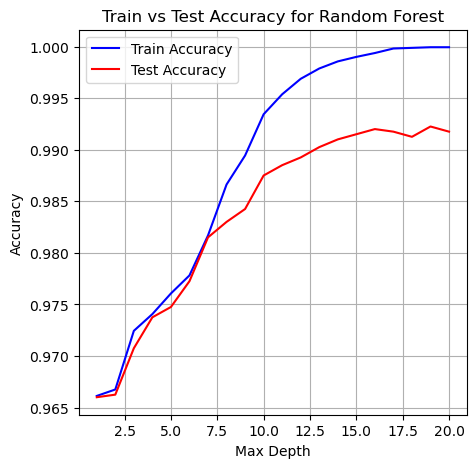

In [81]:
train_accuracies = []
test_accuracies = []

max_depth_values = np.arange(1, 21)

for max_depth in max_depth_values:
    model = RandomForestClassifier(max_depth = max_depth, n_estimators = 123, random_state = 42)
    model.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

plt.figure(figsize=(5, 5))
plt.plot(max_depth_values, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(max_depth_values, test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for Random Forest')
plt.legend()
plt.grid(True)
plt.show()

### which features are the most important?

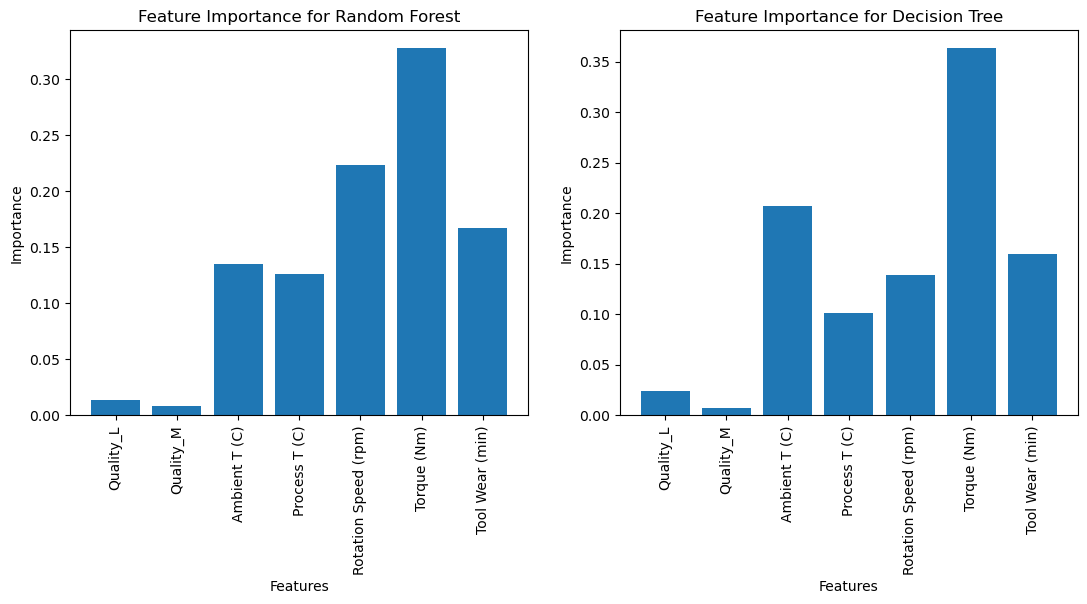

In [89]:
best_rf = grid2.best_estimator_
best_dt = dt_grid1.best_estimator_
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 5))

ax1.bar(X_train.columns, best_rf.feature_importances_)
ax1.set_title('Feature Importance for Random Forest')
ax1.set_xlabel('Features')
ax1.set_ylabel('Importance')
ax1.tick_params(axis = 'x', rotation = 90)

ax2.bar(X_train.columns, best_dt.feature_importances_)
ax2.set_title('Feature Importance for Decision Tree')
ax2.set_xlabel('Features')
ax2.set_ylabel('Importance')
ax2.tick_params(axis = 'x', rotation = 90)

plt.show()